## 8.3 Deep Convolutional Generative Adversarial Network
### Deep Learning, Introducción práctica con Keras - Segunda parte

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time


In [0]:

(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modelos

### Generador

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [0]:
generator = make_generator_model()

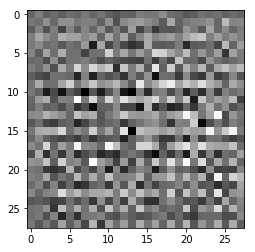

In [0]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminador

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.01))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model



In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary ()

tf.Tensor([[0.4995159]], shape=(1, 1), dtype=float32)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________


## Funciones de *Loss* y optimizadores


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizadores

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrenamiento

###Training step



In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Training loop

In [0]:
grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_images(generator, seed)

### Visualización de las imagenes (en realidad solo las que genera el Generador para ver que va aprendiendo)



In [0]:

def generate_images(model, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
      plt.subplot(grid_size_x, grid_size_y, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')            
  plt.show()

### Entrenar el model

In [0]:
%%time
EPOCHS = 100
train(train_dataset, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import os, signal

os.kill( os.getpid() , 
         signal.SIGKILL
       )